In [1]:
import datacube
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure

#load requiered modules #load r 
import numpy as np
import rasterio
from rasterio import features
#from matplotlib import pyplot as plt #don't need unless want to plot
import xarray as xr
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
#define nessisary gotiff handeling fuctions

import xarray, rasterio, numpy as np
def numpy_to_xarray(array, geobox, name=None):
    """Utility to convert ndarray to DataArray, using a datacube.model.GeoBox"""
    coords=[xarray.Coordinate(x, geobox.coords[x].values, attrs=dict(units=geobox.coords[x].units)) 
            for x in geobox.dims]
    return xarray.DataArray(array, coords=coords, attrs=dict(crs=geobox.crs), name=name)

def geopandas_to_xarray(table, geobox, name=None):
    """Rasterise (with reprojection)"""
    array = rasterio.features.rasterize(shapes=table.to_crs(geobox.crs._crs.ExportToProj4()).geometry,
                                        out_shape=(geobox.height, geobox.width),
                                        transform=geobox.affine)
    return numpy_to_xarray(array, geobox, name)

def rasterfile_to_xarray(file, geobox, name=None, nodata=True, num_bands=(1), X_band= 1):
    """Blit like
    """
    with rasterio.open(file) as src:

        #|assert src.indexes == num_bands # assume single band
        band = rasterio.band(src, X_band) # do not attempt to read entire extent into memory
        array = np.empty((geobox.height, geobox.width), dtype=band.dtype)
        rasterio.warp.reproject(source=band,
                                destination=array,
                                dst_crs=geobox.crs.crs_str,
                                dst_transform=geobox.affine,
                                dst_nodata=nodata)
    return numpy_to_xarray(array, geobox, name)


def load_gfif_full(file_name, x=1):


    dataset = rasterio.open(file_name) #open using Raterio
    {i: dtype for i, dtype in zip(dataset.indexes, dataset.dtypes)}
    data_array = dataset.read(x) #read selected band into np array
    data_xr = xr.DataArray(data_array) #turn into Xr array for fuctionality #Now don't need xr yet
    return(data_xr) #return np array into program 


def part_shp_file(geobox, file_path):
    #ucl_path = "/g/data/v10/wofs/ancillary/ucl/UCL_2011_AUST.shp"
    u = gpd.read_file(file_path) # load shapes table
    #u = u[u['SOS_NAME11']=='Major Urban'] # filter out <100k
    u = u.to_crs(geobox.crs._crs.ExportToProj4()) # reproject
    array = features.rasterize(shapes=zip(u.geometry, u.SecondaryA),
                                        out_shape=(geobox.height, geobox.width),
                                        transform=geobox.affine)
    return numpy_to_xarray(array, geobox, 'urban')


In [3]:
#Temporal range and sensors of interest are defined

#set the number of chunks to pass to dask 
#(bigger chunks will run the dc_load faster, but be careful of hitting memory limits)
ds_chunks = 20

#extents
# extent_long = (145.293, 145.553) reference area??
# extent_lat = (-30.665, -30.404)

extent_long = (148.264306, 148.470191)
extent_lat = (-33.107410, -33.216838)


#query is created
query = {}
query['x'] = extent_long
query['y'] = extent_lat
#query['crs'] = 'EPSG:3577'
#query['dask_chunks']= {'time' : ds_chunks} #divide query into chunks to save memory
    
print(query)

{'x': (148.264306, 148.470191), 'y': (-33.10741, -33.216838)}


In [4]:
#load area dem for geobox
#import datacube
dc = datacube.Datacube()

dsm = dc.load(product='dsm1sv10', **query)

In [5]:
#load mad_trees product

In [6]:
x_data = np.ones((1093,1838))
x_data = xr.DataArray(x_data,name=None)

In [7]:
#load NSW landuse product
#file location

landuse_path = "/g/data/u46/users/ck9738/Datasets/Land_NSW_Landuse_2013/Data/Shapefile/NSW_Landuse_2013.shp"

landuse_data = part_shp_file(dsm.geobox, landuse_path)

I am densified (external_values, 1043185 elements)


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  import sys


In [8]:
"""#load_majorVeggroups

veg_groups_path = '/g/data/u46/users/ck9738/Datasets/NVIS/major_veg_groups.tif'

veggroups_data = rasterfile_to_xarray(veg_groups_path, dsm.geobox, num_bands=(1), X_band=1)"""

/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  import sys


In [9]:
veggroups_data

<xarray.DataArray (latitude: 395, longitude: 742)>
array([[25, 25, 25, ...,  5,  5,  5],
       [25, 25, 25, ...,  5,  5,  5],
       [25, 25, 25, ...,  5,  5,  5],
       ...,
       [25, 25, 25, ..., 29, 25, 25],
       [25, 25, 25, ..., 29, 25, 25],
       [25, 25, 25, ..., 29, 25, 25]], dtype=uint8)
Coordinates:
  * latitude   (latitude) float64 -33.11 -33.11 -33.11 -33.11 -33.11 -33.11 ...
  * longitude  (longitude) float64 148.3 148.3 148.3 148.3 148.3 148.3 148.3 ...
Attributes:
    crs:      EPSG:4326

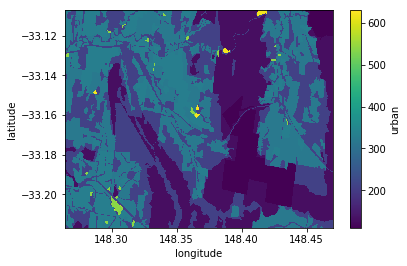

In [10]:
landuse_data.plot();

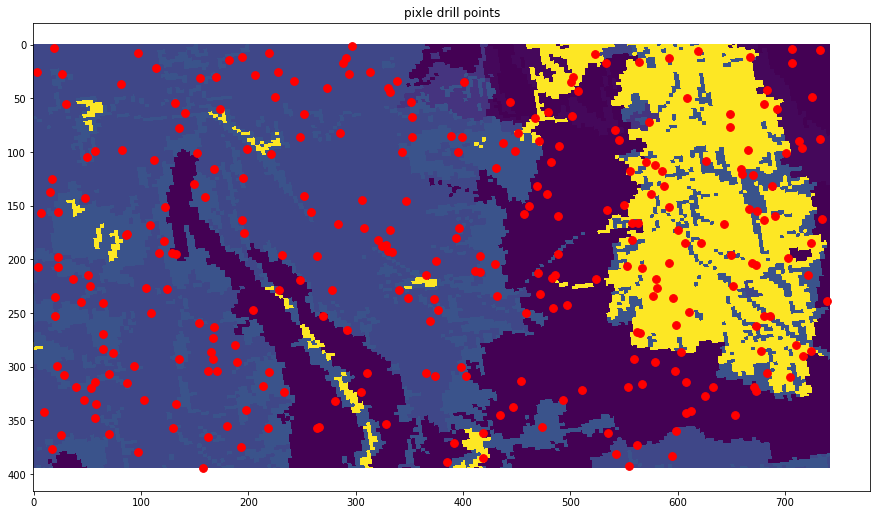

In [11]:
#generate list of random points for 
import random
random.seed()
randlist = [ ( random.randint(1, 741), random.randint(1, 394) ) for k in range(300) ]
#print(randlist)
fig, ax = plt.subplots(figsize = (15,15))
cax = ax.imshow(veggroups_data)
plt.title('pixle drill points')
plt.scatter(*zip(*randlist),c='r', s=60)
#cax.set_clim(0, 35)
plt.show()

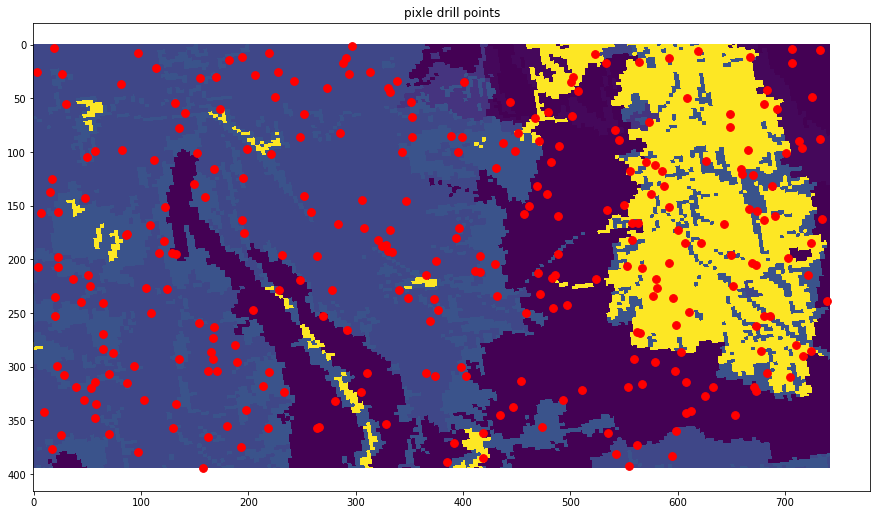

In [12]:
"""fig, ax = plt.subplots(figsize = (15,15))
cax = ax.imshow(veggroups_data)
plt.title('pixle drill points')
plt.scatter(*zip(*randlist),c='r', s=60)
#cax.set_clim(0, 35)
plt.show()"""

In [13]:
mad_data = {}

In [14]:
#begin pixle drill

#define bands to loop through in mad dataset
bands = [1,2,3]

#create dicts to store data

result_dit = dict()

#define count 
count = 0
#begin loop. 
for x,y in randlist:
    mini_dit = dict()#smaller dict to nest in bigger one, this becomes a row in the table

    tup_x = int(x)
    tup_y = int(y)
    count = count+1
    #mini_dit['point']=count
    classifcation = landuse_data.isel(latitude=tup_y,longitude=tup_x)
    lat=(str(classifcation.latitude))
    lon=(str(classifcation.longitude))
    lat_short = lat[39:49]
    lon_short = lon[40:50]
    #print(lat)
    #print(lat_short, lon_short)
    mini_dit['class']=str(classifcation.values)
    mini_dit['latitude']=str(lat_short)
    mini_dit['longitude']=str(lon_short)
    #do Pixle drill for major veggie groups 
    #veggi_group = veggroups_data.isel(latitude=tup_y,longitude=tup_x)
    #mini_dit['Veg_group']=str(veggi_group.values)
    
    
    #loop through all three bands of mad trees

    for band in bands:

        name = 'band '+str(band)
        data = rasterfile_to_xarray('/g/data/u46/users/dxr251/woody-v6/woody_60_-149.tif', dsm.geobox,
                                        num_bands=(1, 2, 3), X_band=band)#load band
        value = data.isel(latitude=tup_y,longitude=tup_x)#pixle drill. 
        mini_dit[name]=str(value.values)
    result_dit[count]=mini_dit
    #end loop
#result_dit
            
            


/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  import sys


In [15]:
new_DLCD_panda = pd.DataFrame(result_dit)
sideways_panda = new_DLCD_panda.transpose()

In [16]:
sideways_panda

,Veg_group,band 1,band 2,band 3,class,latitude,longitude
1,29,0.0019193066,0.45335796,0.44785103,130,-33.192917,148.272083
2,99,0.003799249,0.48517504,0.4688469,320,-33.181806,148.420417
3,29,0.004059567,0.37308404,0.3625304,330,-33.212083,148.269028
4,99,0.0029146054,0.3769107,0.38005012,210,-33.137639,148.422917
5,5,0.0017624757,0.52717596,0.5185486,110,-33.10875),148.467917
6,25,0.013030421,0.4907934,0.4676144,320,-33.118472,148.355972
7,5,0.004499193,0.63476515,0.5831297,130,-33.196806,148.40625)
8,5,0.0013557561,0.53930527,0.52619433,130,-33.210417,148.373194
9,5,0.0029319432,0.58490705,0.57037973,210,-33.195972,148.450694
10,25,0.008293648,0.43804702,0.4225653,320,-33.191806,148.311806


In [17]:
sideways_panda

,Veg_group,band 1,band 2,band 3,class,latitude,longitude
1,29,0.0019193066,0.45335796,0.44785103,130,-33.192917,148.272083
2,99,0.003799249,0.48517504,0.4688469,320,-33.181806,148.420417
3,29,0.004059567,0.37308404,0.3625304,330,-33.212083,148.269028
4,99,0.0029146054,0.3769107,0.38005012,210,-33.137639,148.422917
5,5,0.0017624757,0.52717596,0.5185486,110,-33.10875),148.467917
6,25,0.013030421,0.4907934,0.4676144,320,-33.118472,148.355972
7,5,0.004499193,0.63476515,0.5831297,130,-33.196806,148.40625)
8,5,0.0013557561,0.53930527,0.52619433,130,-33.210417,148.373194
9,5,0.0029319432,0.58490705,0.57037973,210,-33.195972,148.450694
10,25,0.008293648,0.43804702,0.4225653,320,-33.191806,148.311806


In [18]:
sideways_panda.to_csv('/g/data/u46/users/ck9738/Datasets/pixle_drill_4kfold.csv')

In [19]:
x_data = np.random.randint(0,1000,size=(2,10))
x_data

array([[705, 313, 714, 970, 940, 905, 245, 775,  85, 211],
       [209,  43, 518, 964, 791, 696, 121, 386, 307, 646]])

In [20]:
def dataset_to_geotiff(filename, data):

    """
    this function uses rasterio and numpy to write a multi-band geotiff for one
    timeslice, or for a single composite image. It assumes the input data is an
    xarray dataset (note, dataset not dataarray) and that you have crs and affine
    objects attached, and that you are using float data. future users
    may wish to assert that these assumptions are correct.
    Last modified: March 2018
    Authors: Bex Dunn and Josh Sixsmith
    Modified by: Claire Krause, Robbi Bishop-Taylor
    inputs
    filename - string containing filename to write out to
    data - dataset to write out
    Note: this function currently requires the data have lat/lon only, i.e. no
    time dimension
    """

    # Depreciation warning for write_geotiff
    print("This function will be superceded by the 'write_geotiff' function from 'datacube.helpers'. "
          "Please revise your notebooks to use this function instead")

    kwargs = {'driver': 'GTiff',
              'count': len(data.data_vars),  # geomedian no time dim
              'width': data.sizes['x'], 'height': data.sizes['y'],
              'crs': data.crs.crs_str,
              'transform': data.affine,
              'dtype': list(data.data_vars.values())[0].values.dtype,
              'nodata': 0,
              'compress': 'deflate', 'zlevel': 4, 'predictor': 3}
    # for ints use 2 for floats use 3}

    with rasterio.open(filename, 'w', **kwargs) as src:
        for i, band in enumerate(data.data_vars):
            src.write(data[band].data, i + 1)